In [1]:
pd.options.mode.chained_assignment = None

import sys, os
import re
import json

import numpy as np
import requests
import gmaps
import pandas as pd
import matplotlib.pyplot as plt

from api_keys import vacation_key, geo_key
from pprint import pprint

change dir to resources folder

In [2]:
os.chdir(r'Resources')
print(os.getcwd())

C:\Users\wendi\My Drive\project\Resources


# read mask coverage data by State by county

In [3]:
df = pd.read_csv(r'mandates_by_county.csv')

df

,state,county,statefips,countyfips,maskdays,days,maskcoverage
0,AL,Autauga County,1,1,267,493,0.54
1,AL,Baldwin County,1,3,267,493,0.54
2,AL,Barbour County,1,5,267,493,0.54
3,AL,Bibb County,1,7,267,493,0.54
4,AL,Blount County,1,9,267,493,0.54
...,...,...,...,...,...,...,...
3228,PR,Villalba Municipio,72,149,490,493,0.99
3229,PR,Yabucoa Municipio,72,151,490,493,0.99
3230,PR,Yauco Municipio,72,153,490,493,0.99
3231,VI,St. Croix Island,78,10,469,493,0.95


# geocode county for gmaps

In [4]:
# ONLY RUN ONCE FOR GEOCODING data
def geocode_county():
    url = f'http://api.positionstack.com/v1/forward?access_key={geo_key}&query={{}}'

    with open(r'mandates_by_county_geocode.csv', 'w') as fw:
        print(f'state,county,lat,lon,statefips,countyfips,maskdays,days,maskcoverage', file=fw)

        for index, row in df.iterrows():
        #     print(index, list(row))
            state = row[0]
            county = row[1].replace(' ', '%20')
            ctyst = f'{county},%20{state}'

            url1 = url.format(ctyst)
        #     print(url1)
            r = requests.get(url1)
            dicy = r.json()
        #     pprint(dicy)

            lat = dicy['data'][0]['latitude']
            lon = dicy['data'][0]['longitude']

            df.loc[index, 'lat'] = lat
            df.loc[index, 'lon'] = lon

            print(f'{row[0]}, {row[1]}, {lat}, {lon}, {row[2]}, {row[3]}, {row[4]}, {row[5]}, {row[6]}', file=fw)
            print(f'{row[0]}, {row[1]}, {lat}, {lon}, {row[2]}, {row[3]}, {row[4]}, {row[5]}, {row[6]}')

            
# geocode_county()

# read from stored output

In [5]:
df = pd.read_csv(r'mandates_by_county_geocode.csv')

df

,state,county,lat,lon,statefips,countyfips,maskdays,days,maskcoverage
0,AL,Autauga County,32.554052,-86.612433,1,1,267,493,0.54
1,AL,Baldwin County,30.555224,-87.722616,1,3,267,493,0.54
2,AL,Barbour County,31.886628,-85.316973,1,5,267,493,0.54
3,AL,Bibb County,32.999816,-87.099134,1,7,267,493,0.54
4,AL,Blount County,33.957341,-86.562434,1,9,267,493,0.54
...,...,...,...,...,...,...,...,...,...
3228,PR,Villalba Municipio,18.127288,-66.476973,72,149,490,493,0.99
3229,PR,Yabucoa Municipio,18.046734,-65.878242,72,151,490,493,0.99
3230,PR,Yauco Municipio,18.032586,-66.863306,72,153,490,493,0.99
3231,VI,St. Croix Island,17.746706,-64.779172,78,10,469,493,0.95


# plot heatmap of mask mandates over period

In [6]:
gmaps.configure(api_key=vacation_key)

locs = df[['lat', 'lon']]
maskdays = df['maskdays'] 

fig = gmaps.figure()

# add heat layer and set max intensity to max mask days

heat = gmaps.heatmap_layer(locs, weights=maskdays, dissipating=False, max_intensity=maskdays.max(), point_radius = 0.6)
fig.add_layer(heat)

fig

Figure(layout=FigureLayout(height='420px'))

# merge mask mandates and presidential votes return data

format columns and for merge

In [7]:
df['statefips'] = df['statefips'].map('{:0>2d}'.format)
df['countyfips'] = df['countyfips'].map('{:0>3d}'.format)
df['countyfips'] = df['statefips'] + df['countyfips']

df = df.drop(columns='statefips')
df['county'] =  df['county'].map(lambda x: x.upper())
                                 
df

,state,county,lat,lon,countyfips,maskdays,days,maskcoverage
0,AL,AUTAUGA COUNTY,32.554052,-86.612433,01001,267,493,0.54
1,AL,BALDWIN COUNTY,30.555224,-87.722616,01003,267,493,0.54
2,AL,BARBOUR COUNTY,31.886628,-85.316973,01005,267,493,0.54
3,AL,BIBB COUNTY,32.999816,-87.099134,01007,267,493,0.54
4,AL,BLOUNT COUNTY,33.957341,-86.562434,01009,267,493,0.54
...,...,...,...,...,...,...,...,...
3228,PR,VILLALBA MUNICIPIO,18.127288,-66.476973,72149,490,493,0.99
3229,PR,YABUCOA MUNICIPIO,18.046734,-65.878242,72151,490,493,0.99
3230,PR,YAUCO MUNICIPIO,18.032586,-66.863306,72153,490,493,0.99
3231,VI,ST. CROIX ISLAND,17.746706,-64.779172,78010,469,493,0.95


read elections return data by county by year

In [8]:
df1 = pd.read_csv(r'countypres_2000-2020.csv')

df1

,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode
0,2020,ALABAMA,AL,AUTAUGA,1001.0,PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,7503.0,27770.0,20210622,TOTAL
1,2020,ALABAMA,AL,AUTAUGA,1001.0,PRESIDENT,OTHER,OTHER,429.0,27770.0,20210622,TOTAL
2,2020,ALABAMA,AL,AUTAUGA,1001.0,PRESIDENT,DONALD J TRUMP,REPUBLICAN,19838.0,27770.0,20210622,TOTAL
3,2020,ALABAMA,AL,BALDWIN,1003.0,PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,24578.0,109679.0,20210622,TOTAL
4,2020,ALABAMA,AL,BALDWIN,1003.0,PRESIDENT,OTHER,OTHER,1557.0,109679.0,20210622,TOTAL
...,...,...,...,...,...,...,...,...,...,...,...,...
72612,2000,ALASKA,AK,DISTRICT 40,2040.0,PRESIDENT,OTHER,OTHER,119.0,3226.0,20191203,TOTAL
72613,2000,ALASKA,NaN,DISTRICT 99,2099.0,PRESIDENT,AL GORE,DEMOCRAT,NaN,0.0,20191203,TOTAL
72614,2000,ALASKA,NaN,DISTRICT 99,2099.0,PRESIDENT,GEORGE W. BUSH,REPUBLICAN,NaN,0.0,20191203,TOTAL
72615,2000,ALASKA,NaN,DISTRICT 99,2099.0,PRESIDENT,RALPH NADER,GREEN,NaN,0.0,20191203,TOTAL


select time frame before covid and after covid for comparison

In [9]:
df1 = df1[df1['year'] > 2015]

df1

,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode
0,2020,ALABAMA,AL,AUTAUGA,1001.0,PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,7503.0,27770.0,20210622,TOTAL
1,2020,ALABAMA,AL,AUTAUGA,1001.0,PRESIDENT,OTHER,OTHER,429.0,27770.0,20210622,TOTAL
2,2020,ALABAMA,AL,AUTAUGA,1001.0,PRESIDENT,DONALD J TRUMP,REPUBLICAN,19838.0,27770.0,20210622,TOTAL
3,2020,ALABAMA,AL,BALDWIN,1003.0,PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,24578.0,109679.0,20210622,TOTAL
4,2020,ALABAMA,AL,BALDWIN,1003.0,PRESIDENT,OTHER,OTHER,1557.0,109679.0,20210622,TOTAL
...,...,...,...,...,...,...,...,...,...,...,...,...
31562,2016,ALASKA,AK,DISTRICT 40,2040.0,PRESIDENT,DONALD TRUMP,REPUBLICAN,1377.0,4610.0,20191203,TOTAL
31563,2016,ALASKA,AK,DISTRICT 40,2040.0,PRESIDENT,OTHER,OTHER,895.0,4610.0,20191203,TOTAL
31564,2016,ALASKA,NaN,DISTRICT 99,2099.0,PRESIDENT,HILLARY CLINTON,DEMOCRAT,274.0,5056.0,20191203,TOTAL
31565,2016,ALASKA,NaN,DISTRICT 99,2099.0,PRESIDENT,DONALD TRUMP,REPUBLICAN,40.0,5056.0,20191203,TOTAL


get only democrat and repub rows

In [10]:
df1 = df1[df1['party'] != 'OTHER'].reset_index(drop=True)

df1

,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode
0,2020,ALABAMA,AL,AUTAUGA,1001.0,PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,7503.0,27770.0,20210622,TOTAL
1,2020,ALABAMA,AL,AUTAUGA,1001.0,PRESIDENT,DONALD J TRUMP,REPUBLICAN,19838.0,27770.0,20210622,TOTAL
2,2020,ALABAMA,AL,BALDWIN,1003.0,PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,24578.0,109679.0,20210622,TOTAL
3,2020,ALABAMA,AL,BALDWIN,1003.0,PRESIDENT,DONALD J TRUMP,REPUBLICAN,83544.0,109679.0,20210622,TOTAL
4,2020,ALABAMA,AL,BARBOUR,1005.0,PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,4816.0,10518.0,20210622,TOTAL
...,...,...,...,...,...,...,...,...,...,...,...,...
24378,2016,ALASKA,AK,DISTRICT 39,2039.0,PRESIDENT,DONALD TRUMP,REPUBLICAN,1405.0,5639.0,20191203,TOTAL
24379,2016,ALASKA,AK,DISTRICT 40,2040.0,PRESIDENT,HILLARY CLINTON,DEMOCRAT,2338.0,4610.0,20191203,TOTAL
24380,2016,ALASKA,AK,DISTRICT 40,2040.0,PRESIDENT,DONALD TRUMP,REPUBLICAN,1377.0,4610.0,20191203,TOTAL
24381,2016,ALASKA,NaN,DISTRICT 99,2099.0,PRESIDENT,HILLARY CLINTON,DEMOCRAT,274.0,5056.0,20191203,TOTAL


pick out relevant cols and rename

In [11]:
df2 = df1[['year', 'state_po', 'county_name', 'county_fips', 'party', 'candidatevotes', 'totalvotes']]
df2.columns = ['year', 'state', 'county', 'countyfips', 'party', 'votes', 'totvotes']

df2

,year,state,county,countyfips,party,votes,totvotes
0,2020,AL,AUTAUGA,1001.0,DEMOCRAT,7503.0,27770.0
1,2020,AL,AUTAUGA,1001.0,REPUBLICAN,19838.0,27770.0
2,2020,AL,BALDWIN,1003.0,DEMOCRAT,24578.0,109679.0
3,2020,AL,BALDWIN,1003.0,REPUBLICAN,83544.0,109679.0
4,2020,AL,BARBOUR,1005.0,DEMOCRAT,4816.0,10518.0
...,...,...,...,...,...,...,...
24378,2016,AK,DISTRICT 39,2039.0,REPUBLICAN,1405.0,5639.0
24379,2016,AK,DISTRICT 40,2040.0,DEMOCRAT,2338.0,4610.0
24380,2016,AK,DISTRICT 40,2040.0,REPUBLICAN,1377.0,4610.0
24381,2016,NaN,DISTRICT 99,2099.0,DEMOCRAT,274.0,5056.0


drop na rows

In [12]:
df2 = df2.dropna().reset_index(drop=True)

df2

,year,state,county,countyfips,party,votes,totvotes
0,2020,AL,AUTAUGA,1001.0,DEMOCRAT,7503.0,27770.0
1,2020,AL,AUTAUGA,1001.0,REPUBLICAN,19838.0,27770.0
2,2020,AL,BALDWIN,1003.0,DEMOCRAT,24578.0,109679.0
3,2020,AL,BALDWIN,1003.0,REPUBLICAN,83544.0,109679.0
4,2020,AL,BARBOUR,1005.0,DEMOCRAT,4816.0,10518.0
...,...,...,...,...,...,...,...
24357,2016,AK,DISTRICT 38,2038.0,REPUBLICAN,1143.0,5095.0
24358,2016,AK,DISTRICT 39,2039.0,DEMOCRAT,3142.0,5639.0
24359,2016,AK,DISTRICT 39,2039.0,REPUBLICAN,1405.0,5639.0
24360,2016,AK,DISTRICT 40,2040.0,DEMOCRAT,2338.0,4610.0


create proportion of votes var

In [13]:
df2['voteperc'] = df2['votes'] / df2['totvotes']

df2

,year,state,county,countyfips,party,votes,totvotes,voteperc
0,2020,AL,AUTAUGA,1001.0,DEMOCRAT,7503.0,27770.0,0.270184
1,2020,AL,AUTAUGA,1001.0,REPUBLICAN,19838.0,27770.0,0.714368
2,2020,AL,BALDWIN,1003.0,DEMOCRAT,24578.0,109679.0,0.224090
3,2020,AL,BALDWIN,1003.0,REPUBLICAN,83544.0,109679.0,0.761714
4,2020,AL,BARBOUR,1005.0,DEMOCRAT,4816.0,10518.0,0.457882
...,...,...,...,...,...,...,...,...
24357,2016,AK,DISTRICT 38,2038.0,REPUBLICAN,1143.0,5095.0,0.224338
24358,2016,AK,DISTRICT 39,2039.0,DEMOCRAT,3142.0,5639.0,0.557191
24359,2016,AK,DISTRICT 39,2039.0,REPUBLICAN,1405.0,5639.0,0.249158
24360,2016,AK,DISTRICT 40,2040.0,DEMOCRAT,2338.0,4610.0,0.507158


format all columns

In [14]:
df2['countyfips'] = df2['countyfips'].map(int).map('{:0>5d}'.format)

df2

,year,state,county,countyfips,party,votes,totvotes,voteperc
0,2020,AL,AUTAUGA,01001,DEMOCRAT,7503.0,27770.0,0.270184
1,2020,AL,AUTAUGA,01001,REPUBLICAN,19838.0,27770.0,0.714368
2,2020,AL,BALDWIN,01003,DEMOCRAT,24578.0,109679.0,0.224090
3,2020,AL,BALDWIN,01003,REPUBLICAN,83544.0,109679.0,0.761714
4,2020,AL,BARBOUR,01005,DEMOCRAT,4816.0,10518.0,0.457882
...,...,...,...,...,...,...,...,...
24357,2016,AK,DISTRICT 38,02038,REPUBLICAN,1143.0,5095.0,0.224338
24358,2016,AK,DISTRICT 39,02039,DEMOCRAT,3142.0,5639.0,0.557191
24359,2016,AK,DISTRICT 39,02039,REPUBLICAN,1405.0,5639.0,0.249158
24360,2016,AK,DISTRICT 40,02040,DEMOCRAT,2338.0,4610.0,0.507158


merge mask mandates and presidential votes data then drop dup cols

In [15]:
df3 = df2.merge(df, how='inner', on=['state', 'countyfips'], suffixes=('','_y'))
df3 = df3.drop(columns='county_y')

df3

,year,state,county,countyfips,party,votes,totvotes,voteperc,lat,lon,maskdays,days,maskcoverage
0,2020,AL,AUTAUGA,01001,DEMOCRAT,7503.0,27770.0,0.270184,32.554052,-86.612433,267,493,0.54
1,2020,AL,AUTAUGA,01001,REPUBLICAN,19838.0,27770.0,0.714368,32.554052,-86.612433,267,493,0.54
2,2016,AL,AUTAUGA,01001,DEMOCRAT,5936.0,24973.0,0.237697,32.554052,-86.612433,267,493,0.54
3,2016,AL,AUTAUGA,01001,REPUBLICAN,18172.0,24973.0,0.727666,32.554052,-86.612433,267,493,0.54
4,2020,AL,BALDWIN,01003,DEMOCRAT,24578.0,109679.0,0.224090,30.555224,-87.722616,267,493,0.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24120,2016,WY,WESTON,56045,REPUBLICAN,3033.0,3526.0,0.860182,43.841038,-104.567826,66,493,0.13
24121,2016,CA,SAN JOAQUIN,06077,DEMOCRAT,121124.0,224166.0,0.540332,37.961720,-121.277745,424,493,0.86
24122,2016,CA,SAN JOAQUIN,06077,REPUBLICAN,88936.0,224166.0,0.396742,37.961720,-121.277745,424,493,0.86
24123,2016,DC,DISTRICT OF COLUMBIA,11001,DEMOCRAT,282830.0,311268.0,0.908638,38.912097,-77.014683,386,493,0.78


# Combine dem and rep rows into by State by county

separate into two dfs

In [16]:
dfd = df3[df3['party'] == 'DEMOCRAT'].reset_index(drop=True)
dfr = df3[df3['party'] == 'REPUBLICAN'].reset_index(drop=True)

combine dfs in by State by county

In [17]:
dfnew = dfd.merge(dfr, left_index=True, right_index=True, suffixes=('','_r'))
dfnew['dmargin'] = dfnew['voteperc'] - dfnew['voteperc_r']

dfnew

,year,state,county,countyfips,party,votes,totvotes,voteperc,lat,lon,...,party_r,votes_r,totvotes_r,voteperc_r,lat_r,lon_r,maskdays_r,days_r,maskcoverage_r,dmargin
0,2020,AL,AUTAUGA,01001,DEMOCRAT,7503.0,27770.0,0.270184,32.554052,-86.612433,...,REPUBLICAN,19838.0,27770.0,0.714368,32.554052,-86.612433,267,493,0.54,-0.444184
1,2016,AL,AUTAUGA,01001,DEMOCRAT,5936.0,24973.0,0.237697,32.554052,-86.612433,...,REPUBLICAN,18172.0,24973.0,0.727666,32.554052,-86.612433,267,493,0.54,-0.489969
2,2020,AL,BALDWIN,01003,DEMOCRAT,24578.0,109679.0,0.224090,30.555224,-87.722616,...,REPUBLICAN,83544.0,109679.0,0.761714,30.555224,-87.722616,267,493,0.54,-0.537623
3,2016,AL,BALDWIN,01003,DEMOCRAT,18458.0,95215.0,0.193856,30.555224,-87.722616,...,REPUBLICAN,72883.0,95215.0,0.765457,30.555224,-87.722616,267,493,0.54,-0.571601
4,2020,AL,BARBOUR,01005,DEMOCRAT,4816.0,10518.0,0.457882,31.886628,-85.316973,...,REPUBLICAN,5622.0,10518.0,0.534512,31.886628,-85.316973,267,493,0.54,-0.076631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8183,2016,WY,WASHAKIE,56043,DEMOCRAT,532.0,3814.0,0.139486,43.916244,-107.538740,...,REPUBLICAN,2911.0,3814.0,0.763241,43.916244,-107.538740,66,493,0.13,-0.623755
8184,2020,WY,WESTON,56045,DEMOCRAT,360.0,3560.0,0.101124,43.841038,-104.567826,...,REPUBLICAN,3107.0,3560.0,0.872753,43.841038,-104.567826,66,493,0.13,-0.771629
8185,2016,WY,WESTON,56045,DEMOCRAT,299.0,3526.0,0.084799,43.841038,-104.567826,...,REPUBLICAN,3033.0,3526.0,0.860182,43.841038,-104.567826,66,493,0.13,-0.775383
8186,2016,CA,SAN JOAQUIN,06077,DEMOCRAT,121124.0,224166.0,0.540332,37.961720,-121.277745,...,REPUBLICAN,88936.0,224166.0,0.396742,37.961720,-121.277745,424,493,0.86,0.143590


# plot dem party heatmap since 2016

In [18]:
# Democrat
dfd2020 = dfnew[dfnew['dmargin'] > 0]

gmaps.configure(api_key=vacation_key)

locs = dfd2020[['lat', 'lon']]
dmargin = dfd2020['dmargin'] * 100

fig = gmaps.figure()

# add heat layer and set max intensity to max mask days
heat = gmaps.heatmap_layer(locs, weights=dmargin, dissipating=False, max_intensity=dmargin.max(), point_radius = 1)
fig.add_layer(heat)

fig

Figure(layout=FigureLayout(height='420px'))

# plot rep party heatmap since 2016

In [19]:
#REPUBLICAN
dfd2016 = dfnew[dfnew['dmargin'] < 0]

gmaps.configure(api_key=vacation_key)

locs = dfd2016[['lat', 'lon']]
dmargin = dfd2016['dmargin'] * 100 * - 1

fig = gmaps.figure()

# add heat layer and set max intensity to max mask days
heat = gmaps.heatmap_layer(locs, weights=dmargin, dissipating=False, max_intensity=dmargin.max() * 4, point_radius = 1)
fig.add_layer(heat)

fig

Figure(layout=FigureLayout(height='420px'))

# regress to uncover relationship between political alignment and mask mandates

In [20]:
dfnew

,year,state,county,countyfips,party,votes,totvotes,voteperc,lat,lon,...,party_r,votes_r,totvotes_r,voteperc_r,lat_r,lon_r,maskdays_r,days_r,maskcoverage_r,dmargin
0,2020,AL,AUTAUGA,01001,DEMOCRAT,7503.0,27770.0,0.270184,32.554052,-86.612433,...,REPUBLICAN,19838.0,27770.0,0.714368,32.554052,-86.612433,267,493,0.54,-0.444184
1,2016,AL,AUTAUGA,01001,DEMOCRAT,5936.0,24973.0,0.237697,32.554052,-86.612433,...,REPUBLICAN,18172.0,24973.0,0.727666,32.554052,-86.612433,267,493,0.54,-0.489969
2,2020,AL,BALDWIN,01003,DEMOCRAT,24578.0,109679.0,0.224090,30.555224,-87.722616,...,REPUBLICAN,83544.0,109679.0,0.761714,30.555224,-87.722616,267,493,0.54,-0.537623
3,2016,AL,BALDWIN,01003,DEMOCRAT,18458.0,95215.0,0.193856,30.555224,-87.722616,...,REPUBLICAN,72883.0,95215.0,0.765457,30.555224,-87.722616,267,493,0.54,-0.571601
4,2020,AL,BARBOUR,01005,DEMOCRAT,4816.0,10518.0,0.457882,31.886628,-85.316973,...,REPUBLICAN,5622.0,10518.0,0.534512,31.886628,-85.316973,267,493,0.54,-0.076631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8183,2016,WY,WASHAKIE,56043,DEMOCRAT,532.0,3814.0,0.139486,43.916244,-107.538740,...,REPUBLICAN,2911.0,3814.0,0.763241,43.916244,-107.538740,66,493,0.13,-0.623755
8184,2020,WY,WESTON,56045,DEMOCRAT,360.0,3560.0,0.101124,43.841038,-104.567826,...,REPUBLICAN,3107.0,3560.0,0.872753,43.841038,-104.567826,66,493,0.13,-0.771629
8185,2016,WY,WESTON,56045,DEMOCRAT,299.0,3526.0,0.084799,43.841038,-104.567826,...,REPUBLICAN,3033.0,3526.0,0.860182,43.841038,-104.567826,66,493,0.13,-0.775383
8186,2016,CA,SAN JOAQUIN,06077,DEMOCRAT,121124.0,224166.0,0.540332,37.961720,-121.277745,...,REPUBLICAN,88936.0,224166.0,0.396742,37.961720,-121.277745,424,493,0.86,0.143590


define regression function to be reused

In [21]:
def reg_plot(x_l, y_l):
    x = np.array(x_l)
    y = np.array(y_l)

    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m * x + b, color='#000000', linewidth ='3', label = '{:.2f} * x + {:.2f}'.format(m, b))
    plt.legend()
    
    return m, b

create data and fig variables

In [22]:
color = ['#043070', '#700804']

x = dfnew['dmargin'] * 100
y = dfnew['maskcoverage'] * 100
xy = zip(x, y)

dem = {}
rep = {}
for percvote, percmask in xy:
    if percvote >= 0:
        dem[percvote] = percmask
    else:
        rep[percvote] = percmask

# plot mask mandates against politcal alignment since 2016

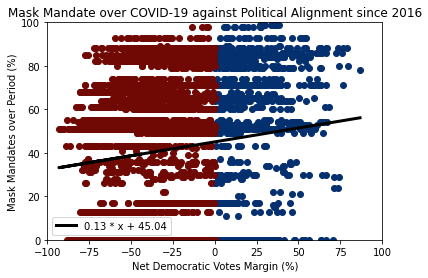

In [23]:
plt.scatter(dem.keys(), dem.values(), c=color[0])
plt.scatter(rep.keys(), rep.values(), c=color[1])

plt.title('Mask Mandate over COVID-19 against Political Alignment since 2016')
plt.xlabel('Net Democratic Votes Margin (%)')
plt.ylabel('Mask Mandates over Period (%)')
plt.xlim(-100,100)
plt.ylim(0,100)

corr = reg_plot(x, y)

plt.savefig('..\Images\mandates_votes_overall.png', dpi=200)
plt.show()

separate data into 2016 and 2020

In [24]:
dfnew2020 = dfnew[dfnew['year'] == 2020]
dfnew2016 = dfnew[dfnew['year'] == 2016]

# plot mask mandates against 2020 political alignment

In [25]:
x = dfnew2020['dmargin'] * 100
y = dfnew2020['maskcoverage'] * 100
xy = zip(x, y)

dem = {}
rep = {}
for percvote, percmask in xy:
    if percvote >= 0:
        dem[percvote] = percmask
    else:
        rep[percvote] = percmask

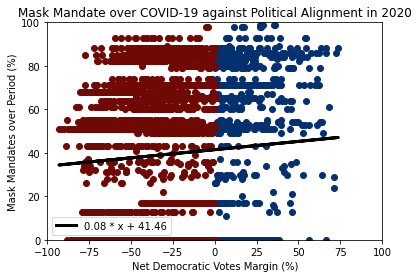

In [26]:
plt.scatter(dem.keys(), dem.values(), c=color[0])
plt.scatter(rep.keys(), rep.values(), c=color[1])

plt.title('Mask Mandate over COVID-19 against Political Alignment in 2020')
plt.xlabel('Net Democratic Votes Margin (%)')
plt.ylabel('Mask Mandates over Period (%)')
plt.xlim(-100,100)
plt.ylim(0,100)

corr = reg_plot(x, y)

plt.savefig('..\Images\mandates_votes_2020.png', dpi=200)
plt.show()

# plot mask mandates against 2016 political alignment

In [27]:
x = dfnew2016['dmargin'] * 100
y = dfnew2016['maskcoverage'] * 100
xy = zip(x, y)

dem = {}
rep = {}
for percvote, percmask in xy:
    if percvote >= 0:
        dem[percvote] = percmask
    else:
        rep[percvote] = percmask

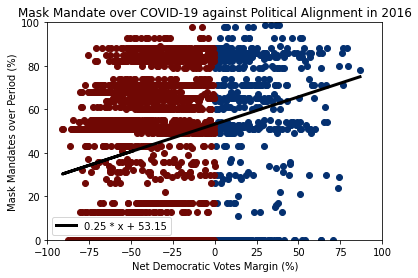

In [28]:
plt.scatter(dem.keys(), dem.values(), c=color[0])
plt.scatter(rep.keys(), rep.values(), c=color[1])

plt.title('Mask Mandate over COVID-19 against Political Alignment in 2016')
plt.xlabel('Net Democratic Votes Margin (%)')
plt.ylabel('Mask Mandates over Period (%)')
plt.xlim(-100,100)
plt.ylim(0,100)

corr = reg_plot(x, y)

plt.savefig('..\Images\mandates_votes_2016.png', dpi=200)
plt.show()